# NYTimes Mini Crossword Time Forecasting

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [24]:
from matplotlib import rcParams

rcParams['figure.figsize'] = (12, 6)

In [25]:
data_file = "crossword_times.csv"

In [26]:
df_data = pd.read_csv(data_file)
df_data["date"] = pd.to_datetime(df_data["date"])
df_data.head()

,date,day_of_week,time
0,2020-04-16,5,41.0
1,2020-04-17,6,37.0
2,2020-04-18,7,457.0
3,2020-04-19,1,43.0
4,2020-04-20,2,69.0


In [27]:
# what's the date range?
print(min(df_data["date"]))
print(max(df_data["date"]))

2020-04-16 00:00:00
2023-03-18 00:00:00


In [28]:
# let's allocate 2.5 years for the training set, 
# and let's try hard to block off the remaining data until later.
# possible there's a bit of distribution shift, but let's see
train_start = pd.Timestamp("2020-04-16")
train_end = pd.Timestamp("2022-10-16")

# most used as the "test set" in the training set
val_start = pd.Timestamp("2022-04-17")
val_end = train_end

In [29]:
df_train = df_data[(df_data["date"] >= train_start) & (df_data["date"] <= train_end)]
df_train.head()

,date,day_of_week,time
0,2020-04-16,5,41.0
1,2020-04-17,6,37.0
2,2020-04-18,7,457.0
3,2020-04-19,1,43.0
4,2020-04-20,2,69.0


<AxesSubplot:xlabel='time', ylabel='Count'>

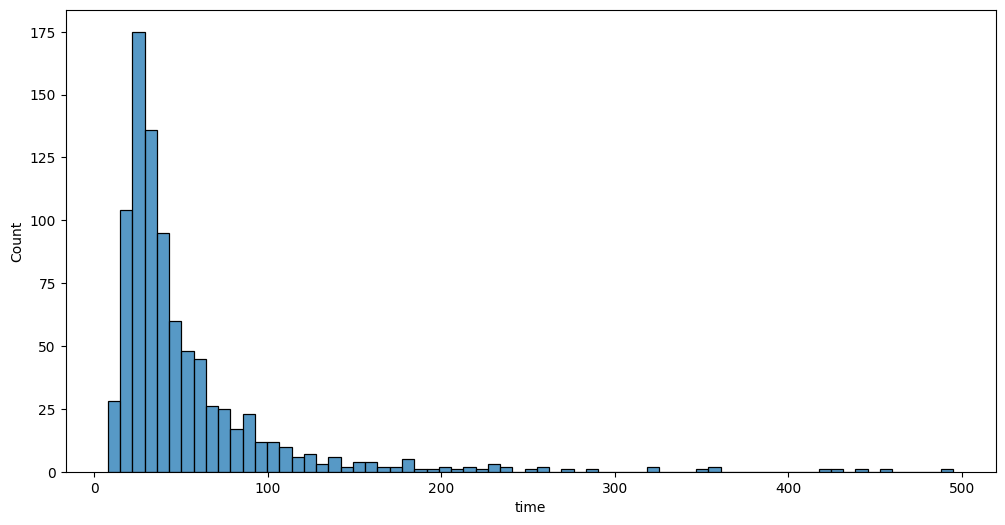

In [30]:
# check the distribution of values -- of course, they're skewed
sns.histplot(data=df_train, x="time")

/Users/asjchen/Documents/mini-crossword-forecasts/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:xlabel='log_time', ylabel='Count'>

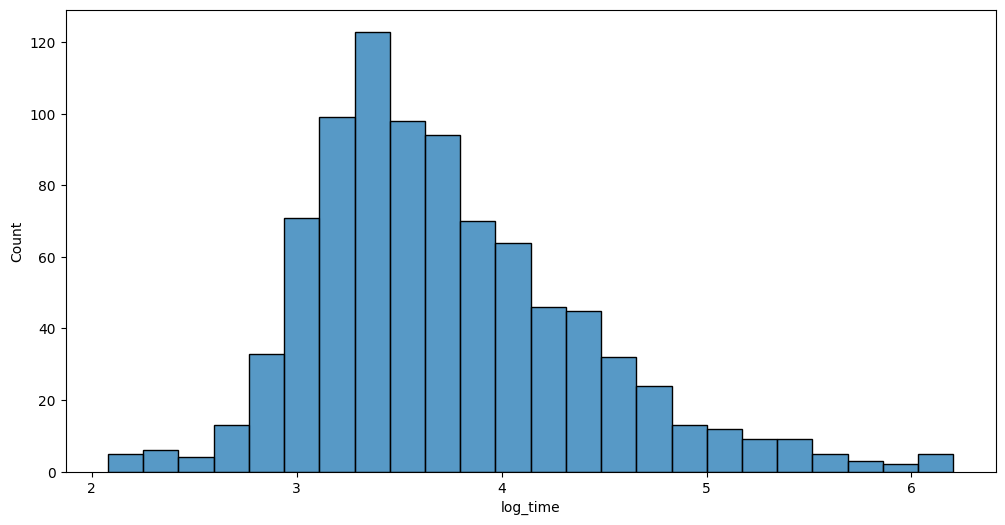

In [31]:
# what about a log transform first? (no risk of zeros) 
# that's not bad actually! not quite symmetrical / normal, but okay
df_train["log_time"] = np.log(df_train["time"])
sns.histplot(data=df_train, x="log_time")

In [32]:
# alright, let's use log_time instead as the y var

<AxesSubplot:xlabel='date', ylabel='time'>

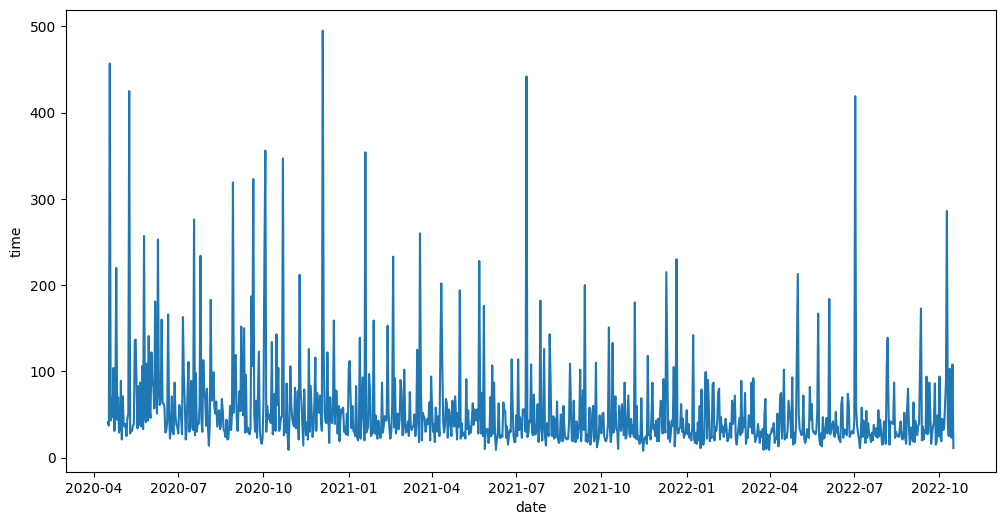

In [33]:
# also general plot -- the spikes might be hard to predict on
sns.lineplot(data=df_train, x="date", y="time")

## Baseline Model

In [37]:
class CrosswordForecaster:
    def __init__(self, target_col: str) -> None:
        self.target_col = target_col
    
    def fit(self, df_data: pd.DataFrame) -> None:
        pass
    
    # only predict one time-step at a time
    def predict(self, df_data: pd.DataFrame) -> pd.DataFrame:
        pass
    
    # after predicting time t, we can access the true value at time t 
    # before predicting t+1, but without refitting the model on the new information.
    # NOTE: the test days may not be contiguous
    def predict_batch(self, df_data: pd.DataFrame, num_test_days: int) -> pd.DataFrame:
        pass


In [40]:
class EMAForecaster(CrosswordForecaster):
    def __init__(self, target_col: str, alpha: float) -> None:
        super().__init__(target_col)
        self.alpha = alpha
    
    # note: this method ignores gaps in the data -- each row
    # is a timestep here
    def predict(self, df_data: pd.DataFrame) -> pd.DataFrame:
        return df_data[self.target_col].ewm(alpha=self.alpha).iloc[-1]
    
    def predict_batch(self, df_data: pd.DataFrame, num_test_days: int) -> pd.DataFrame:
        return df_data[self.target_col].ewm(alpha=self.alpha).iloc[-num_test_days:]
    

In [ ]:
# TODO: make sure I'm accounting for missing data